In [4]:
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from PIL import Image

import tensorflow as tf
import IPython.display as display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

import os, pathlib, math, datetime

In [2]:
# graphwiz path variable
os.environ["PATH"] += os.pathsep + "D:/Program Files (x86)/Graphviz2.38/bin/"

# autotune constant
autotune = tf.data.experimental.AUTOTUNE

## Download the dataset using Kaggle API
```
!kaggle datasets download -d nitishabharathi/scene-classification
```

In [3]:
path = "C:\\Users\Ridzuan\.keras\datasets\\"
dir_name = "intel_dataset"
data_dir = pathlib.Path(path + dir_name)

print("Data directory :", data_dir)
print("Content: ", os.listdir(data_dir))

Data directory : C:\Users\Ridzuan\.keras\datasets\intel_dataset
Content:  ['seg_pred', 'seg_test', 'seg_train']


In [4]:
# set directories for prediction, testing and training
train_dir = pathlib.Path(os.path.join(data_dir, "seg_train\seg_train"))
test_dir = pathlib.Path(os.path.join(data_dir, "seg_test\seg_test"))
pred_dir = pathlib.Path(os.path.join(data_dir, "seg_pred\seg_pred"))

In [5]:
train_dir

WindowsPath('C:/Users/Ridzuan/.keras/datasets/intel_dataset/seg_train/seg_train')

In [9]:
# check amount of data in training directory
image_count = len(list(train_dir.glob("*/*.jpg")))
print(image_count)

14034


In [10]:
# perform image statistics
size_images = dict()

for dirpath, _, filenames in os.walk(train_dir):
   for path_image in filenames:
      image = os.path.abspath(os.path.join(dirpath, path_image))
      with Image.open(image) as img:
         width, heigth = img.size
         size_images[path_image] = {
            'width': width, 
            'heigth': heigth
         }

In [11]:
df_size_images = pd.DataFrame(size_images).T
df_size_images.describe()

,width,heigth
count,14034.0,14034.000000
mean,150.0,149.908722
std,0.0,1.873124
min,150.0,76.000000
25%,150.0,150.000000
50%,150.0,150.000000
75%,150.0,150.000000
max,150.0,150.000000


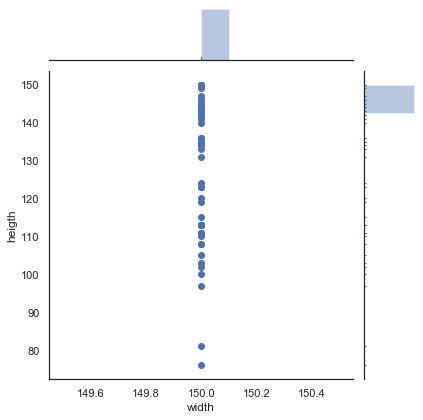

In [12]:
sns.set(style="white", color_codes=True)
sns.jointplot(
   x = "width", 
   y = "heigth", 
   data = df_size_images,
   marginal_kws=dict(bins=10, rug=True),
)

In [13]:
# check directory content
os.listdir(train_dir)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [14]:
# get labels based on the directories and ignore other file
class_names = np.array([
   item.name for item in train_dir.glob("*") if item.name != "LICENSE.txt"
])

print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


## Random sampling

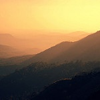

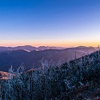

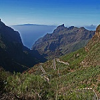

<Figure size 720x432 with 0 Axes>

In [15]:
mountains = list(
   train_dir.glob("mountain/*")
)

plt.figure(figsize = (10, 6))
for image_path in mountains[:3]:
   display.display(Image.open(str(image_path)).resize((100, 100)))

In [18]:
list_train_dataset = tf.data.Dataset.list_files(
   str(train_dir/"*/*")
)

list_test_dataset = tf.data.Dataset.list_files(
   str(test_dir/"*/*")
)

list_train_dataset

<ShuffleDataset shapes: (), types: tf.string>

In [19]:
batch_size = 32
img_dim = 125

def get_label(file_path):
   parts = tf.strings.split(file_path, os.path.sep)
   return parts[-2] == class_names

def decode_image(img):
   img = tf.image.decode_jpeg(img, channels = 3)
   img = tf.image.convert_image_dtype(img, tf.float32)
   return tf.image.resize_with_crop_or_pad(img, img_dim, img_dim)

def process_path(file_path):
   label = get_label(file_path)
   img = tf.io.read_file(file_path)
   img = decode_image(img)
   return img, label

In [20]:
labeled_train_ds = list_train_dataset.map(
   process_path,
   num_parallel_calls = autotune
)

labeled_test_ds = list_test_dataset.map(
   process_path,
   num_parallel_calls = autotune
)

In [21]:
print("Variable {} now is type of {}\n".format("labeled_ds", type(labeled_train_ds)))
print("Data specifications:")
print(labeled_train_ds.element_spec , "\n")

Variable labeled_ds now is type of <class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>

Data specifications:
(TensorSpec(shape=(125, 125, 3), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.bool, name=None)) 



In [22]:
for image, label in labeled_train_ds.take(1):
   print("Image shape: ", image.numpy().shape)
   print("LAbel: ", label.numpy())

Image shape:  (125, 125, 3)
LAbel:  [False False False False  True False]


In [23]:
def prepare_for_training(dataset, cache = True, shuffle_buffer_size = 1000):
   
   if cache:
      if isinstance(cache, str):
         dataset = dataset.cache(cache)
      else:
         dataset = dataset.cache()
         
   dataset = dataset.shuffle(buffer_size = shuffle_buffer_size).repeat().batch(batch_size).prefetch(buffer_size = autotune)
   
   return dataset

In [24]:
prepared_train_data = prepare_for_training(labeled_train_ds)
prepared_test_data = prepare_for_training(labeled_test_ds)

In [25]:
# function to random sampling batch
def show_batch(image_batch, label_batch):
   plt.figure(figsize = (10, 10))
   for n in range(25):
      plt.subplot(5, 5, n + 1)
      plt.imshow(image_batch[n])
      plt.title(class_names[label_batch[n] == 1][0].title())
      plt.axis("off")

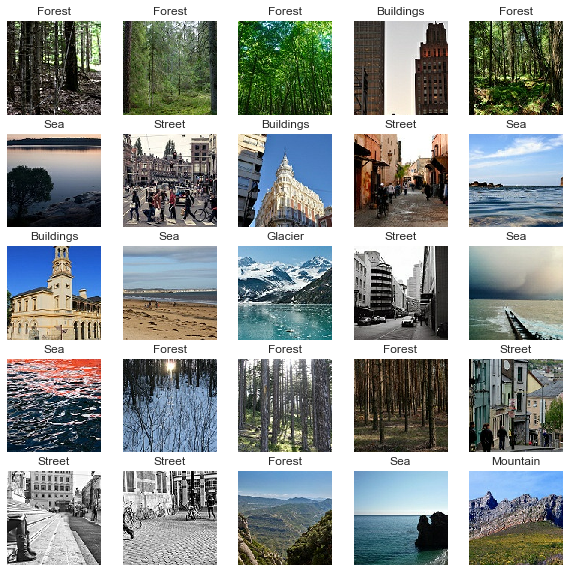

In [26]:
# batch sampling
image_batch, label_batch = next(iter(prepared_train_data))
show_batch(image_batch.numpy(), label_batch.numpy())

In [29]:
model = Sequential([
   Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_dim, img_dim, 3)),
   MaxPooling2D(),
   Dropout(0.2),
   Conv2D(32, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Dropout(0.2),
   Conv2D(64, 3, padding='same', activation='relu'),
   MaxPooling2D(),
   Dropout(0.2),
   Flatten(),
   Dense(512, activation='relu'),
   Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

logdir = os.path.join(
   "logs\\intel_dataset",
   datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
   logdir,
   histogram_freq = 1
)

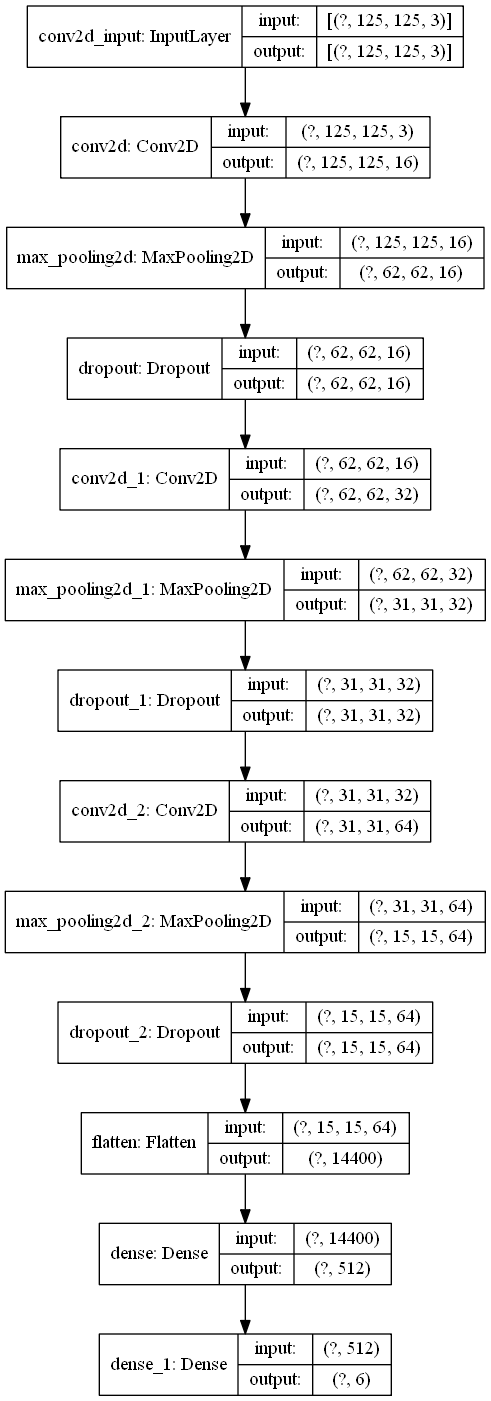

In [30]:
plot_model(model, show_shapes = True, expand_nested = True)

In [148]:
history = model.fit_generator(
   prepared_train_data,
   epochs=10,
   steps_per_epoch = 100,
   validation_data = prepared_test_data,
   validation_steps = 100,
   callbacks = [tensorboard_callback]
)

Train for 100 steps, validate for 100 steps
Epoch 1/10
100/100 [==============================] - 46s 461ms/step - loss: 0.3959 - accuracy: 0.8467 - val_loss: 0.3247 - val_accuracy: 0.8596
Epoch 2/10
100/100 [==============================] - 43s 428ms/step - loss: 0.2923 - accuracy: 0.8756 - val_loss: 0.2830 - val_accuracy: 0.8729
Epoch 3/10
100/100 [==============================] - 44s 437ms/step - loss: 0.2740 - accuracy: 0.8795 - val_loss: 0.2844 - val_accuracy: 0.8734
Epoch 4/10
100/100 [==============================] - 45s 450ms/step - loss: 0.2543 - accuracy: 0.8904 - val_loss: 0.2656 - val_accuracy: 0.8843
Epoch 5/10
100/100 [==============================] - 52s 516ms/step - loss: 0.2331 - accuracy: 0.9029 - val_loss: 0.2265 - val_accuracy: 0.9051
Epoch 6/10
100/100 [==============================] - 52s 520ms/step - loss: 0.2234 - accuracy: 0.9075 - val_loss: 0.2459 - val_accuracy: 0.8967
Epoch 7/10
100/100 [==============================] - 50s 498ms/step - loss: 0.2078 - 

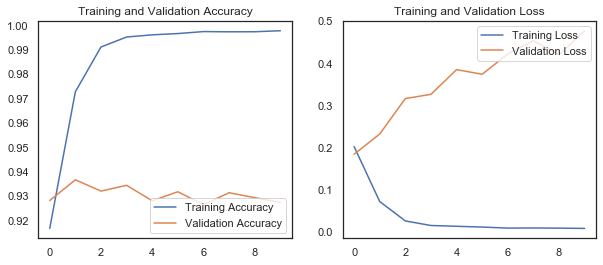

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()